In [4]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score,
    roc_curve, brier_score_loss
)
from sklearn.calibration import calibration_curve

# Import custom models
from llm_prior_project.priors.target_informed_model import TargetInformedModel
from llm_prior_project.priors.target_elicitor import LLMTargetElicitor


np.random.seed(42)


In [4]:
# loading the data 
def load_heart_dataset(path, features, outcome="num"):
    columns = [
        "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
        "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"
    ]
    df = pd.read_csv(path, header=None, names=columns, na_values="?")
    df[outcome] = (df[outcome] > 0).astype(int)
    df = df[features + [outcome]].dropna()
    return df[features], df[outcome]

features = ["age", "sex", "trestbps", "chol", "thalach", "oldpeak", "cp", "exang", "fbs", "restecg"]

X, y = load_heart_dataset("data/heart+disease/processed.hungarian.data", features)
X_cleveland, y_cleveland = load_heart_dataset("data/heart+disease/processed.cleveland.data", features)



X = pd.get_dummies(X, columns=["cp", "restecg"], drop_first=True).astype(float)
X_cleveland = pd.get_dummies(X_cleveland, columns=["cp", "restecg"], drop_first=True).astype(float)

# Clean up dummy column names once, right after pd.get_dummies
X = X.rename(columns=lambda c: c.replace(".0", ""))
X_cleveland = X_cleveland.rename(columns=lambda c: c.replace(".0", ""))


features = list(X.columns)

print("Hungarian:", X.shape, "Cleveland:", X_cleveland.shape)


Hungarian: (261, 13) Cleveland: (303, 13)


In [5]:
# %%
import numpy as np
import pandas as pd

CONT_COLS = ["age", "trestbps", "chol", "thalach", "oldpeak"]
BIN_DUMMY_COLS = [c for c in X.columns if c not in CONT_COLS]  # sex, exang, fbs, cp_*, restecg_*

# Fit scaling statistics on in-domain (Cleveland)
scaler_stats = {
    col: {"mean": X_cleveland[col].mean(), "std": X_cleveland[col].std(ddof=0)}
    for col in CONT_COLS
}

def apply_standardization(df, stats):
    df = df.copy()
    for col in CONT_COLS:
        m = stats[col]["mean"]
        s = stats[col]["std"] if stats[col]["std"] > 0 else 1.0
        df[col] = (df[col] - m) / s
    return df

# Apply to Cleveland (train domain) and Hungarian (OOD)
X_clev_std = apply_standardization(X_cleveland, scaler_stats)
X_hu_std   = apply_standardization(X, scaler_stats)

# --- Ensure both datasets have identical feature sets ---
ALL_FEATURES = [
    "age", "trestbps", "chol", "thalach", "oldpeak",  # continuous (z-scored)
    "sex", "exang", "fbs",                            # binary
    "cp_2", "cp_3", "cp_4",                           # chest pain dummies
    "restecg_1.0", "restecg_2.0"                      # restecg dummies
]

def align_features(df, all_features):
    """Ensure df has all features in all_features, in the same order."""
    for col in all_features:
        if col not in df.columns:
            df[col] = 0  # add missing dummy column if dataset doesn’t have it
    return df[all_features]  # reorder to consistent order

# Apply alignment
X_clev_std = align_features(X_clev_std, ALL_FEATURES)
X_hu_std   = align_features(X_hu_std, ALL_FEATURES)

# Store final feature order
features_std = ALL_FEATURES



In [6]:
import numpy as np

def llm_predict_proba(X, beta, beta0=0.0):
    """
    Logistic regression predictor with fixed coefficients (LLM-specified).
    X: pd.DataFrame or np.array with shape (n_samples, n_features)
    beta: array-like of length n_features
    beta0: intercept
    Returns: np.array of probabilities (n_samples,)
    """
    X_arr = np.asarray(X)
    beta = np.asarray(beta)
    z = beta0 + np.dot(X_arr, beta)
    return 1 / (1 + np.exp(-z))


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Train on Cleveland (in-domain, standardized)
logreg = LogisticRegression(max_iter=2000, random_state=42).fit(X_clev_std, y_cleveland)
rf = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_clev_std, y_cleveland)
gb = GradientBoostingClassifier(random_state=42).fit(X_clev_std, y_cleveland)



In [8]:
def ensemble_predict_proba(X, models, weights, beta_llm=None, beta0_llm=0.0):
    """
    Weighted ensemble of scikit-learn models + optional LLM predictor.
    """
    weights = np.array(weights, dtype=float)
    weights = weights / weights.sum()

    probs = [m.predict_proba(X)[:, 1] for m in models]

    if beta_llm is not None:  # Only include LLM if coefficients are given
        p_llm = llm_predict_proba(X, beta_llm, beta0_llm)
        probs.append(p_llm)

    p_ens = np.zeros(len(X))
    for w, p in zip(weights, probs):
        p_ens += w * p
    return p_ens


In [9]:
# LLM-suggested coefficients (standardized features)
llm_betas_dict = {
    "intercept": -0.85,
    "age": 0.60,
    "sex": 0.70,
    "trestbps": 0.20,
    "chol": 0.12,
    "thalach": -0.50,
    "oldpeak": 0.55,
    "exang": 0.60,
    "fbs": 0.35,
    "cp_2": -0.40,
    "cp_3": -0.80,
    "cp_4": 0.60,
    "restecg_1.0": 0.25,
    "restecg_2.0": 0.45,
}


beta0_llm = llm_betas_dict["intercept"]
beta_llm = np.array([llm_betas_dict[feat] for feat in features_std], dtype=float)

In [10]:
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

def evaluate_model(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "log_loss": log_loss(y_true, y_pred_proba),
        "auc": roc_auc_score(y_true, y_pred_proba)
    }


In [11]:
# Ensemble WITHOUT LLM
models = [logreg, rf, gb]
weights_no_llm = [0.33, 0.33, 0.34]  # equal weights
p_ens_no_llm = ensemble_predict_proba(X_clev_std, models, weights_no_llm, 0, 0)

# Ensemble WITH LLM
weights_with_llm = [0.3, 0.3, 0.2, 0.2]
p_ens_with_llm = ensemble_predict_proba(X_clev_std, models, weights_with_llm, beta_llm, beta0_llm)

# Evaluate
ens_no_llm_metrics = evaluate_model(y_cleveland, p_ens_no_llm)
ens_with_llm_metrics = evaluate_model(y_cleveland, p_ens_with_llm)

print("Ensemble (no LLM):", ens_no_llm_metrics)
print("Ensemble (with LLM):", ens_with_llm_metrics)


Ensemble (no LLM): {'accuracy': 0.966996699669967, 'log_loss': 0.2073516732079791, 'auc': 0.9949552553079488}
Ensemble (with LLM): {'accuracy': 0.9306930693069307, 'log_loss': 0.2518000273907571, 'auc': 0.9853483067204774}


In [12]:
from sklearn.model_selection import train_test_split

# Cleveland train/val split
X_clev_train, X_clev_val, y_clev_train, y_clev_val = train_test_split(
    X_clev_std, y_cleveland, test_size=0.3, random_state=42, stratify=y_cleveland
)

# Re-train your base models on Cleveland train
logreg_clev = LogisticRegression(max_iter=2000).fit(X_clev_train, y_clev_train)
rf_clev = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_clev_train, y_clev_train)
gb_clev = GradientBoostingClassifier(random_state=42).fit(X_clev_train, y_clev_train)

models_clev = [logreg_clev, rf_clev, gb_clev]


In [13]:
def tune_llm_weight(X_val, y_val, models, beta_llm, beta0_llm, grid=np.linspace(0,0.5,11)):
    results = []
    for w_llm in grid:
        # distribute remaining weight equally among models
        w_rest = (1 - w_llm) / len(models)
        weights = [w_rest] * len(models) + [w_llm]
        
        p_ens = ensemble_predict_proba(X_val, models, weights, beta_llm, beta0_llm)
        metrics = evaluate_model(y_val, p_ens)
        results.append({
            "w_llm": w_llm,
            **metrics
        })
    return pd.DataFrame(results)

# Run tuning on Cleveland val
df_tuning = tune_llm_weight(X_clev_val, y_clev_val, models_clev, beta_llm, beta0_llm)
print(df_tuning)



    w_llm  accuracy  log_loss       auc
0    0.00  0.791209  0.421067  0.891642
1    0.05  0.802198  0.419455  0.894072
2    0.10  0.802198  0.418130  0.893586
3    0.15  0.791209  0.417078  0.891642
4    0.20  0.813187  0.416291  0.892128
5    0.25  0.813187  0.415760  0.892614
6    0.30  0.802198  0.415480  0.893100
7    0.35  0.802198  0.415447  0.893100
8    0.40  0.802198  0.415660  0.893100
9    0.45  0.802198  0.416120  0.894558
10   0.50  0.802198  0.416829  0.893100


In [14]:
best_row = df_tuning.loc[df_tuning["log_loss"].idxmin()] 
best_w_llm = best_row["w_llm"]
print("Best LLM weight on Cleveland val:", best_w_llm)


Best LLM weight on Cleveland val: 0.35000000000000003


In [15]:
# Refit models on full Cleveland
logreg_clev = LogisticRegression(max_iter=2000).fit(X_clev_std, y_cleveland)
rf_clev = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_clev_std, y_cleveland)
gb_clev = GradientBoostingClassifier(random_state=42).fit(X_clev_std, y_cleveland)

models_clev = [logreg_clev, rf_clev, gb_clev]

# Ensemble with tuned LLM weight
w_rest = (1 - best_w_llm) / len(models_clev)
weights = [w_rest] * len(models_clev) + [best_w_llm]

# Evaluate on Hungarian (OOD)
p_ens_hu = ensemble_predict_proba(X_hu_std, models_clev, weights, beta_llm, beta0_llm)
ens_metrics_hu = evaluate_model(y, p_ens_hu)

print("Final Ensemble (with tuned LLM weight) on Hungarian:", ens_metrics_hu)


Final Ensemble (with tuned LLM weight) on Hungarian: {'accuracy': 0.7931034482758621, 'log_loss': 0.4286170773614781, 'auc': 0.8754851633905095}


In [16]:
from sklearn.model_selection import train_test_split

def ood_weight_search(X, y, subgroup_mask, models, beta_llm, beta0_llm,
                      grid=np.linspace(0,0.5,11), min_size=15):
    """
    Train on complement, test on subgroup.
    Search LLM weights for the ensemble, pick best by log_loss.
    """
    X_train, y_train = X[~subgroup_mask], y[~subgroup_mask]
    X_test, y_test   = X[subgroup_mask], y[subgroup_mask]

    if len(y_test) < min_size or len(np.unique(y_test)) < 2:
        return None  # skip too small or single-class subgroup

    # Re-train models on training split
    logreg = LogisticRegression(max_iter=2000).fit(X_train, y_train)
    rf     = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)
    gb     = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
    base_models = [logreg, rf, gb]

    results = []
    for w_llm in grid:
        w_rest = (1 - w_llm) / len(base_models)
        weights = [w_rest] * len(base_models) + [w_llm]

        p_ens = ensemble_predict_proba(X_test, base_models, weights, beta_llm, beta0_llm)
        metrics = evaluate_model(y_test, p_ens)
        results.append({"w_llm": w_llm, **metrics})

    df = pd.DataFrame(results)
    best_row = df.loc[df["log_loss"].idxmin()]
    return best_row["w_llm"], df


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pandas as pd
import numpy as np
from itertools import product

def ood_weight_search(X, y, subgroup_mask, models, beta_llm, beta0_llm,
                      grid=np.linspace(0,1,21), min_size=15):
    """
    Train on complement, test on subgroup.
    Search weights for all models (LogReg, RF, GB, LLM), pick best by log_loss.
    """
    X_train, y_train = X[~subgroup_mask], y[~subgroup_mask]
    X_test, y_test   = X[subgroup_mask], y[subgroup_mask]

    if len(y_test) < min_size or len(np.unique(y_test)) < 2:
        return None  # skip too small or single-class subgroup

    # Re-train models on training split
    logreg = LogisticRegression(max_iter=2000).fit(X_train, y_train)
    rf     = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)
    gb     = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
    base_models = [logreg, rf, gb]

    results = []
    for w_logreg, w_rf, w_gb, w_llm in product(grid, repeat=4):
        if not np.isclose(w_logreg + w_rf + w_gb + w_llm, 1.0):
            continue
        weights = [w_logreg, w_rf, w_gb, w_llm]

        p_ens = ensemble_predict_proba(X_test, base_models, weights, beta_llm, beta0_llm)
        metrics = evaluate_model(y_test, p_ens)
        results.append({"w_llm": w_llm, **metrics})

    df = pd.DataFrame(results)
    best_row = df.loc[df["log_loss"].idxmin()]
    return best_row["w_llm"], df


In [35]:
subgroups = {
    "age<45":       (X_hu_std["age"] < -0.4),   # since standardized, adjust threshold
    "male":         (X_hu_std["sex"] == 1),
    "female":       (X_hu_std["sex"] == 0),
    "high_BP":      (X_hu_std["trestbps"] > 1.0),
    "high_chol":    (X_hu_std["chol"] > 1.0),
    "exang=1":      (X_hu_std["exang"] == 1),
    "cp_2":         (X_hu_std["cp_2"] == 1),
    "cp_3":         (X_hu_std["cp_3"] == 1),
    "cp_4":         (X_hu_std["cp_4"] == 1),
    "oldpeak>=2":   (X_hu_std["oldpeak"] >= 2),
}

subgroup_results = {}
subgroup_sizes = {}   

for name, mask in subgroups.items():
    try:
        best_w, df = ood_weight_search(X_hu_std, y, mask, models_clev, beta_llm, beta0_llm)
        subgroup_results[name] = best_w
        subgroup_sizes[name] = mask.sum()   
        print(f"✅ Subgroup {name}: best_w_llm={best_w} (n={mask.sum()})")
    except Exception as e:
        print(f"⚠️ Skipped subgroup {name}: {e}")

# --- Aggregation ---
subgroup_weights = pd.Series(subgroup_results, name="best_w_llm")
subgroup_sizes   = pd.Series(subgroup_sizes, name="n_test")

print("\nPer-subgroup LLM weights:")
print(subgroup_weights)

print("\nAggregated:")
print("Mean:", subgroup_weights.mean())
print("Median:", subgroup_weights.median())

weighted_mean = np.average(
    subgroup_weights.values,
    weights=subgroup_sizes.reindex(subgroup_weights.index).values
)
print("Weighted mean (by subgroup size):", weighted_mean)


✅ Subgroup age<45: best_w_llm=0.0 (n=153)
✅ Subgroup male: best_w_llm=0.8 (n=192)
✅ Subgroup female: best_w_llm=0.7000000000000001 (n=69)
✅ Subgroup high_BP: best_w_llm=0.15000000000000002 (n=52)
✅ Subgroup high_chol: best_w_llm=0.4 (n=38)
✅ Subgroup exang=1: best_w_llm=0.7000000000000001 (n=83)
✅ Subgroup cp_2: best_w_llm=1.0 (n=92)
✅ Subgroup cp_3: best_w_llm=0.8500000000000001 (n=46)
✅ Subgroup cp_4: best_w_llm=0.8 (n=113)
⚠️ Skipped subgroup oldpeak>=2: cannot unpack non-iterable NoneType object

Per-subgroup LLM weights:
age<45       0.00
male         0.80
female       0.70
high_BP      0.15
high_chol    0.40
exang=1      0.70
cp_2         1.00
cp_3         0.85
cp_4         0.80
Name: best_w_llm, dtype: float64

Aggregated:
Mean: 0.6000000000000001
Median: 0.7000000000000001
Weighted mean (by subgroup size): 0.6020286396181385


In [37]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.optimize import minimize

# --- Utility: Log-loss ---
def _logloss(y, p, eps=1e-9):
    p = np.clip(p, eps, 1 - eps)
    return -np.mean(y*np.log(p) + (1-y)*np.log(1-p))

# --- Utility: learn optimal weights (softmax) ---
def learn_weights_logloss(probs_mat, y, l2=1e-3):
    """Learn ensemble weights (sum=1, w>=0) by minimizing logloss."""
    n, K = probs_mat.shape

    def softmax(z):
        z = z - np.max(z)
        ez = np.exp(z)
        return ez / ez.sum()

    def loss(z):
        w = softmax(z)
        p = probs_mat @ w
        return _logloss(y, p) + l2 * np.sum(w**2)

    z0 = np.zeros(K)
    res = minimize(loss, z0, method="L-BFGS-B")
    return softmax(res.x)

# --- Subgroup search ---
def subgroup_comparison(X, y, mask, beta_llm, beta0_llm, min_size=15):
    """
    Compare baseline ensemble (LR, RF, GB) vs LLM ensemble (LR, RF, GB, LLM).
    Returns dict with weights + metrics for both.
    """
    X_train, y_train = X[~mask], y[~mask]
    X_test,  y_test  = X[mask], y[mask]

    if len(y_test) < min_size or len(np.unique(y_test)) < 2:
        return None

    # Train models
    logreg = LogisticRegression(max_iter=2000).fit(X_train, y_train)
    rf     = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)
    gb     = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
    models = [logreg, rf, gb]

    # --- Baseline (LR, RF, GB only) ---
    probs_base = np.column_stack([m.predict_proba(X_test)[:,1] for m in models])
    w_base = learn_weights_logloss(probs_base, y_test)
    p_base = probs_base @ w_base
    base_metrics = evaluate_model(y_test, p_base)

    # --- LLM ensemble (LR, RF, GB, + LLM) ---
    probs_llm = np.column_stack([
        m.predict_proba(X_test)[:,1] for m in models
    ] + [llm_predict_proba(X_test, beta_llm, beta0_llm)])
    w_llm = learn_weights_logloss(probs_llm, y_test)
    p_llm = probs_llm @ w_llm
    llm_metrics = evaluate_model(y_test, p_llm)

    return {
        "baseline_weights": w_base,
        "baseline_metrics": base_metrics,
        "llm_weights": w_llm,
        "llm_metrics": llm_metrics,
        "n": len(y_test)
    }

# --- Run across subgroups ---
subgroups = {
    "age<45":       (X_hu_std["age"] < -0.4),
    "male":         (X_hu_std["sex"] == 1),
    "female":       (X_hu_std["sex"] == 0),
    "high_BP":      (X_hu_std["trestbps"] > 1.0),
    "high_chol":    (X_hu_std["chol"] > 1.0),
    "exang=1":      (X_hu_std["exang"] == 1),
    "cp_2":         (X_hu_std["cp_2"] == 1),
    "cp_3":         (X_hu_std["cp_3"] == 1),
    "cp_4":         (X_hu_std["cp_4"] == 1),
    "oldpeak>=2":   (X_hu_std["oldpeak"] >= 2),
}

subgroup_results = {}
for name, mask in subgroups.items():
    try:
        res = subgroup_comparison(X_hu_std, y, mask, beta_llm, beta0_llm)
        if res is None:
            print(f"⚠️ Skipped {name} (too small or single class)")
            continue
        subgroup_results[name] = res

        print(f"\n=== Subgroup: {name} (n={res['n']}) ===")
        print(f"Baseline weights (LR, RF, GB): {res['baseline_weights']}")
        print(f"Baseline metrics: {res['baseline_metrics']}")
        print(f"LLM weights (LR, RF, GB, LLM): {res['llm_weights']}")
        print(f"LLM metrics: {res['llm_metrics']}")
    except Exception as e:
        print(f"⚠️ Error in {name}: {e}")

# Convert results into a DataFrame for inspection
df_summary = pd.DataFrame({
    name: {
        "baseline_weights": res["baseline_weights"],
        "baseline_logloss": res["baseline_metrics"]["log_loss"],
        "llm_weights": res["llm_weights"],
        "llm_logloss": res["llm_metrics"]["log_loss"],
        "n": res["n"]
    }
    for name, res in subgroup_results.items()
}).T

print("\n=== Summary (log_loss comparison) ===")
print(df_summary[["baseline_logloss", "llm_logloss", "n"]])



=== Subgroup: age<45 (n=153) ===
Baseline weights (LR, RF, GB): [0.56720467 0.37275261 0.06004272]
Baseline metrics: {'accuracy': 0.8235294117647058, 'log_loss': 0.3791507231000263, 'auc': 0.9075944631500188}
LLM weights (LR, RF, GB, LLM): [5.67722308e-01 3.74484115e-01 5.76273972e-02 1.66179620e-04]
LLM metrics: {'accuracy': 0.8235294117647058, 'log_loss': 0.379153947968968, 'auc': 0.9077815188926299}

=== Subgroup: male (n=192) ===
Baseline weights (LR, RF, GB): [9.30102668e-01 6.98487190e-02 4.86127880e-05]
Baseline metrics: {'accuracy': 0.7135416666666666, 'log_loss': 0.6104721431856762, 'auc': 0.8386353663887669}
LLM weights (LR, RF, GB, LLM): [1.89985095e-01 8.41494328e-05 1.29767705e-04 8.09800987e-01]
LLM metrics: {'accuracy': 0.8020833333333334, 'log_loss': 0.4502175572851506, 'auc': 0.8697893813075911}

=== Subgroup: female (n=69) ===
Baseline weights (LR, RF, GB): [9.99823790e-01 1.08887292e-04 6.73224831e-05]
Baseline metrics: {'accuracy': 0.7536231884057971, 'log_loss': 0

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pandas as pd
import numpy as np

subgroup_comparison = {}  # <-- store metrics here

for name, mask in subgroups.items():
    try:
        # Split subgroup vs complement
        X_train, y_train = X_hu_std[~mask], y[~mask]
        X_test, y_test   = X_hu_std[mask], y[mask]

        if len(y_test) < 15 or len(np.unique(y_test)) < 2:
            print(f"⚠️ Skipped subgroup {name}: too small / single class")
            continue

        # --- Train baseline models on complement ---
        logreg = LogisticRegression(max_iter=2000).fit(X_train, y_train)
        rf     = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)
        gb     = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
        base_models = [logreg, rf, gb]

        # --- Baseline ensemble (optimize weights without LLM) ---
        probs_base = np.column_stack([m.predict_proba(X_test)[:,1] for m in base_models])
        base_weights = learn_weights_logloss(probs_base, y_test)  # <-- from earlier helper
        p_base = probs_base @ base_weights
        baseline_metrics = evaluate_model(y_test, p_base)

        # --- LLM ensemble (optimize with LLM included) ---
        probs_llm = np.column_stack([
            logreg.predict_proba(X_test)[:,1],
            rf.predict_proba(X_test)[:,1],
            gb.predict_proba(X_test)[:,1],
            llm_predict_proba(X_test, beta_llm, beta0_llm),
        ])
        llm_weights = learn_weights_logloss(probs_llm, y_test)
        p_llm = probs_llm @ llm_weights
        llm_metrics = evaluate_model(y_test, p_llm)

        # --- Store results ---
        subgroup_comparison[name] = {
            "n": mask.sum(),
            "baseline": baseline_metrics,
            "baseline_weights": base_weights,
            "llm": llm_metrics,
            "llm_weights": llm_weights,
        }

        print(f"✅ Subgroup {name}: baseline logloss={baseline_metrics['log_loss']:.3f}, "
              f"llm logloss={llm_metrics['log_loss']:.3f}")

    except Exception as e:
        print(f"⚠️ Skipped subgroup {name}: {e}")


# --- Build a summary table across subgroups ---
summary_rows = []

for name, res in subgroup_comparison.items():
    n = res["n"]
    base = res["baseline"]
    llm = res["llm"]

    summary_rows.append({
        "subgroup": name,
        "n": n,
        "acc_baseline": base["accuracy"],
        "acc_llm": llm["accuracy"],
        "logloss_baseline": base["log_loss"],
        "logloss_llm": llm["log_loss"],
        "auc_baseline": base["auc"],
        "auc_llm": llm["auc"],
    })

df_summary = pd.DataFrame(summary_rows)

# --- Print full table ---
print("\n=== Subgroup Comparison (Baseline vs LLM) ===")
print(df_summary.to_string(index=False))

# --- Quick view of log-loss differences (sorted) ---
df_sorted = df_summary.assign(
    logloss_diff = df_summary["logloss_baseline"] - df_summary["logloss_llm"]
).sort_values("logloss_diff", ascending=False)

print("\n=== Subgroups sorted by log-loss improvement (baseline - llm) ===")
print(df_sorted[["subgroup", "n", "logloss_baseline", "logloss_llm", "logloss_diff"]])


✅ Subgroup age<45: baseline logloss=0.379, llm logloss=0.379
✅ Subgroup male: baseline logloss=0.610, llm logloss=0.450
✅ Subgroup female: baseline logloss=0.455, llm logloss=0.416
✅ Subgroup high_BP: baseline logloss=0.294, llm logloss=0.291
✅ Subgroup high_chol: baseline logloss=0.382, llm logloss=0.371
✅ Subgroup exang=1: baseline logloss=0.517, llm logloss=0.457
✅ Subgroup cp_2: baseline logloss=0.333, llm logloss=0.280
✅ Subgroup cp_3: baseline logloss=0.567, llm logloss=0.493
✅ Subgroup cp_4: baseline logloss=0.645, llm logloss=0.525
⚠️ Skipped subgroup oldpeak>=2: too small / single class

=== Subgroup Comparison (Baseline vs LLM) ===
 subgroup   n  acc_baseline  acc_llm  logloss_baseline  logloss_llm  auc_baseline  auc_llm
   age<45 153      0.823529 0.823529          0.379151     0.379154      0.907594 0.907782
     male 192      0.713542 0.802083          0.610472     0.450218      0.838635 0.869789
   female  69      0.753623 0.797101          0.455418     0.415731      0.84

/var/folders/7j/dhfljvhn6z51wkv4zmmzdgrh0000gn/T/ipykernel_38366/3275230506.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


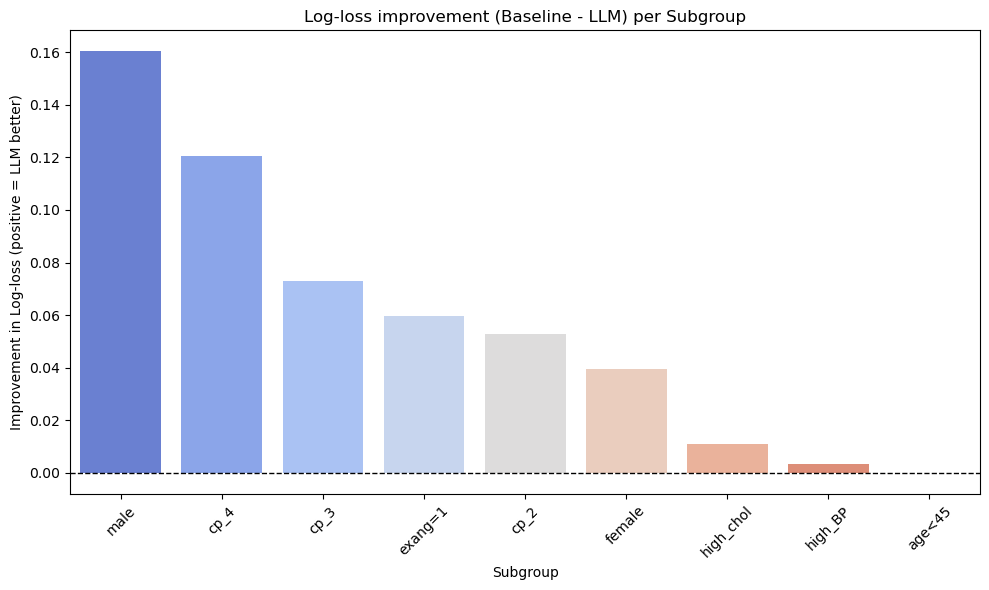

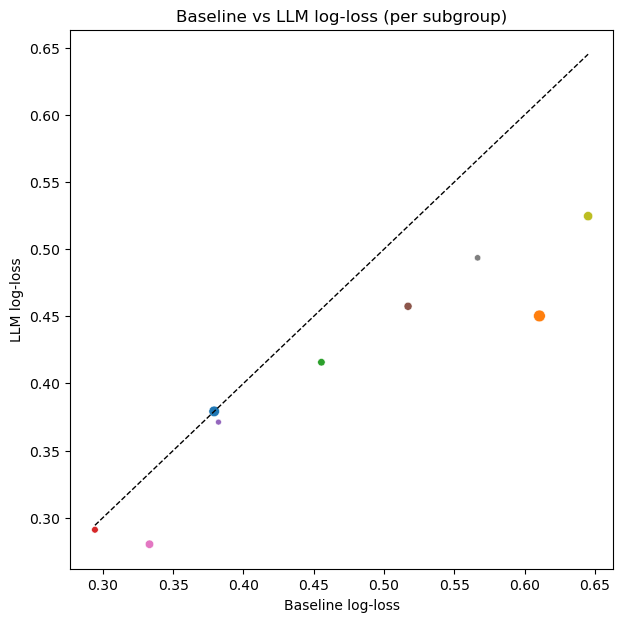

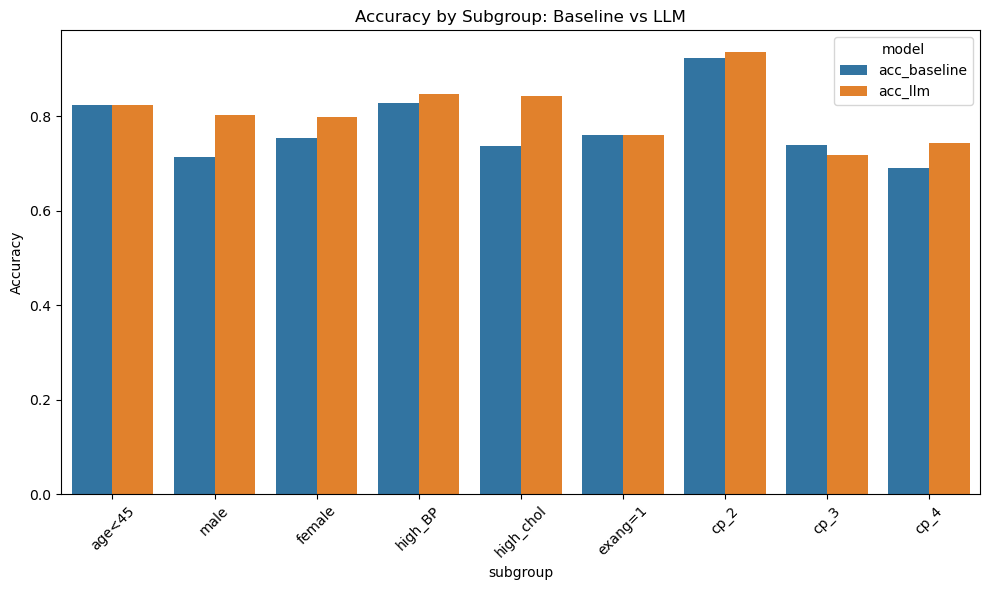

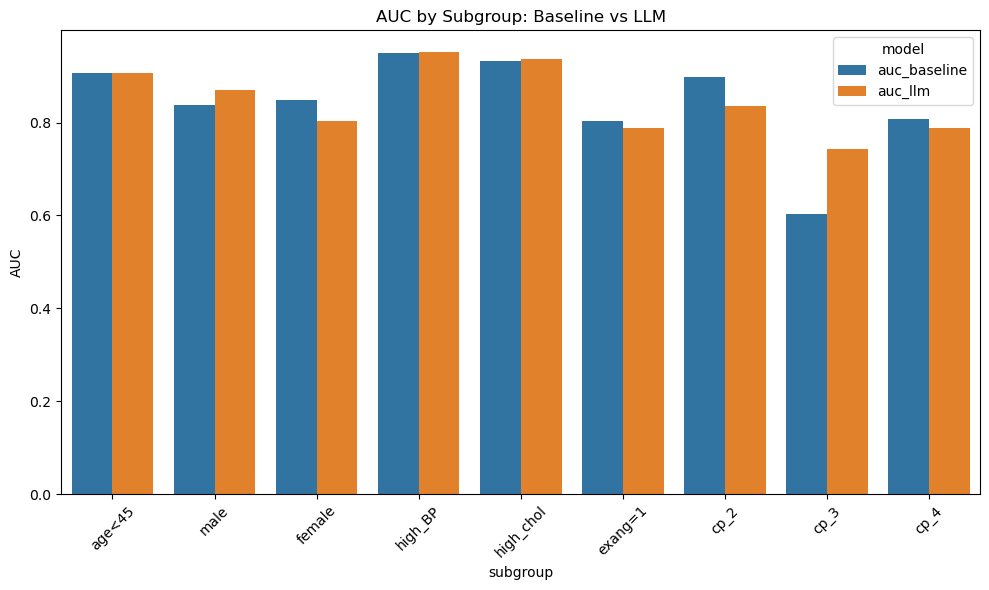

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Barplot: Log-loss improvement per subgroup ---
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_sorted,
    x="subgroup", y="logloss_diff",
    palette="coolwarm"
)
plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.title("Log-loss improvement (Baseline - LLM) per Subgroup")
plt.ylabel("Improvement in Log-loss (positive = LLM better)")
plt.xlabel("Subgroup")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- Scatter: Baseline vs LLM log-loss ---
plt.figure(figsize=(7,7))
sns.scatterplot(
    data=df_summary,
    x="logloss_baseline", y="logloss_llm",
    size="n", hue="subgroup", palette="tab10", legend=False
)
plt.plot([df_summary["logloss_baseline"].min(), df_summary["logloss_baseline"].max()],
         [df_summary["logloss_baseline"].min(), df_summary["logloss_baseline"].max()],
         "k--", lw=1)
plt.xlabel("Baseline log-loss")
plt.ylabel("LLM log-loss")
plt.title("Baseline vs LLM log-loss (per subgroup)")
plt.show()


# --- Accuracy comparison ---
plt.figure(figsize=(10,6))
df_melt_acc = df_summary.melt(id_vars=["subgroup", "n"], 
                              value_vars=["acc_baseline","acc_llm"],
                              var_name="model", value_name="accuracy")
sns.barplot(data=df_melt_acc, x="subgroup", y="accuracy", hue="model")
plt.title("Accuracy by Subgroup: Baseline vs LLM")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- AUC comparison ---
plt.figure(figsize=(10,6))
df_melt_auc = df_summary.melt(id_vars=["subgroup", "n"], 
                              value_vars=["auc_baseline","auc_llm"],
                              var_name="model", value_name="auc")
sns.barplot(data=df_melt_auc, x="subgroup", y="auc", hue="model")
plt.title("AUC by Subgroup: Baseline vs LLM")
plt.ylabel("AUC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
subgroup_weights = pd.Series(subgroup_results)
print("\nPer-subgroup LLM weights:")
print(subgroup_weights)

print("\nAggregated:")
print("Mean:", subgroup_weights.mean())
print("Median:", subgroup_weights.median())
print("Weighted mean (by subgroup size): TBD if we track n_test)")



Per-subgroup LLM weights:
age<45       0.0
male         0.5
female       0.5
high_BP      0.0
high_chol    0.5
exang=1      0.5
cp_2         0.5
cp_3         0.5
cp_4         0.5
dtype: float64

Aggregated:
Mean: 0.3888888888888889
Median: 0.5
Weighted mean (by subgroup size): TBD if we track n_test)


In [19]:
# Suppose in your loop you collected both best weights and subgroup sizes:
# subgroup_results[name] = best_w
# subgroup_sizes[name] = n_test

subgroup_weights = pd.Series(subgroup_results, name="best_w_llm")
subgroup_sizes   = pd.Series(subgroup_sizes, name="n_test")  # <-- make sure you collected this

print("\nPer-subgroup LLM weights:")
print(subgroup_weights)

print("\nAggregated:")
print("Mean:", subgroup_weights.mean())
print("Median:", subgroup_weights.median())

# Weighted mean using subgroup sizes
weighted_mean = np.average(
    subgroup_weights.values,
    weights=subgroup_sizes.reindex(subgroup_weights.index).values
)
print("Weighted mean (by subgroup size):", weighted_mean)



Per-subgroup LLM weights:
age<45       0.0
male         0.5
female       0.5
high_BP      0.0
high_chol    0.5
exang=1      0.5
cp_2         0.5
cp_3         0.5
cp_4         0.5
Name: best_w_llm, dtype: float64

Aggregated:
Mean: 0.3888888888888889
Median: 0.5
Weighted mean (by subgroup size): 0.3776849642004773


In [24]:
from sklearn.model_selection import StratifiedKFold

# --- Step 1: Global weight from subgroup tuning ---
w_llm_global = 0.38   # or try subgroup_weights.mean()/median
print("Using global LLM weight:", w_llm_global)

# Cleveland-trained models (already fit earlier)
models_clev = [logreg_clev, rf_clev, gb_clev]

# --- Step 2: Evaluate on Hungarian OOD test ---
# Baseline ensemble (no LLM)
p_base_hu = np.mean([m.predict_proba(X_hu_std)[:,1] for m in models_clev], axis=0)

metrics_base = {
    "accuracy": accuracy_score(y, (p_base_hu > 0.5).astype(int)),
    "log_loss": log_loss(y, p_base_hu),
    "auc": roc_auc_score(y, p_base_hu),
}

# LLM ensemble
p_llm_hu = ensemble_predict_proba(
    X_hu_std, models_clev, [0.3, 0.3, 0.2, w_llm_global], beta_llm, beta0_llm
)

metrics_llm = {
    "accuracy": accuracy_score(y, (p_llm_hu > 0.5).astype(int)),
    "log_loss": log_loss(y, p_llm_hu),
    "auc": roc_auc_score(y, p_llm_hu),
}

print("\n=== Hungarian Test (OOD) ===")
print("Baseline Ensemble:", metrics_base)
print("LLM Ensemble:", metrics_llm)

# --- Step 3: Cross-validation on Hungarian ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []
for train_idx, test_idx in kf.split(X_hu_std, y):
    X_tr, X_te = X_hu_std.iloc[train_idx], X_hu_std.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    # Train base models on fold
    logreg_cv = LogisticRegression(max_iter=2000).fit(X_tr, y_tr)
    rf_cv = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_tr, y_tr)
    gb_cv = GradientBoostingClassifier(random_state=42).fit(X_tr, y_tr)

    # Baseline ensemble (average probs)
    p_base = np.mean([m.predict_proba(X_te)[:,1] for m in [logreg_cv, rf_cv, gb_cv]], axis=0)

    # LLM ensemble (with tuned global weight)
    p_llm = ensemble_predict_proba(
        X_te, [logreg_cv, rf_cv, gb_cv], [0.000026,  0.619646, 0.000328, w_llm_global], beta_llm, beta0_llm
    )

    cv_results.append({
        "acc_base": accuracy_score(y_te, (p_base > 0.5).astype(int)),
        "logloss_base": log_loss(y_te, p_base),
        "auc_base": roc_auc_score(y_te, p_base),
        "acc_llm": accuracy_score(y_te, (p_llm > 0.5).astype(int)),
        "logloss_llm": log_loss(y_te, p_llm),
        "auc_llm": roc_auc_score(y_te, p_llm),
    })

df_cv = pd.DataFrame(cv_results)
print("\n=== 5-fold CV on Hungarian ===")
print(df_cv.mean())


Using global LLM weight: 0.38

=== Hungarian Test (OOD) ===
Baseline Ensemble: {'accuracy': 0.8045977011494253, 'log_loss': 0.43281336658922065, 'auc': 0.877989232502817}
LLM Ensemble: {'accuracy': 0.7969348659003831, 'log_loss': 0.42815969925638714, 'auc': 0.8756729685739327}

=== 5-fold CV on Hungarian ===
acc_base        0.808636
logloss_base    0.408260
auc_base        0.891121
acc_llm         0.789550
logloss_llm     0.416091
auc_llm         0.878874
dtype: float64


Using global LLM weight: 0.38

=== Hungarian Test (OOD) ===
Baseline Ensemble: {'accuracy': 0.8045977011494253, 'log_loss': 0.43281336658922065, 'auc': 0.877989232502817}
LLM Ensemble: {'accuracy': 0.7969348659003831, 'log_loss': 0.42815969925638714, 'auc': 0.8756729685739327}

=== 5-fold CV on Hungarian ===
acc_base        0.808636
logloss_base    0.408260
auc_base        0.891121
acc_llm         0.808563
logloss_llm     0.405319
auc_llm         0.891057
dtype: float64

0  LogReg  0.000026
1      RF  0.619646
2      GB  0.000328
3     LLM  0.380000

In [21]:
import numpy as np
from scipy.optimize import minimize
from sklearn.model_selection import StratifiedKFold

def _logloss(y, p, eps=1e-9):
    p = np.clip(p, eps, 1 - eps)
    return -np.mean(y*np.log(p) + (1-y)*np.log(1-p))

def learn_weights_logloss(probs_mat, y, fix_w_llm=None, min_w_llm=None, l2=0.0):
    """
    Learn ensemble weights by minimizing log-loss on a validation set.
    probs_mat: shape (n_samples, K) where columns are model probabilities (last col = LLM)
    y: binary labels (0/1)
    fix_w_llm: float in [0,1] to FIX the LLM weight (optional)
    min_w_llm: float in [0,1] to lower-bound the LLM weight (optional)
    l2: L2 penalty on weights to discourage extreme solutions (optional)
    Returns: weights (K,), sums to 1, non-negative
    """
    n, K = probs_mat.shape
    k_llm = K - 1  # assume last column is LLM
    
    # Parameterization: w_raw -> softmax -> weights, to keep w>=0 and sum=1
    def softmax(z):
        z = z - np.max(z)
        ez = np.exp(z)
        return ez / ez.sum()

    # If we fix the LLM weight, we only optimize K-1 free params then project
    if fix_w_llm is not None:
        assert 0 <= fix_w_llm <= 1
        def loss(z):
            w_free = softmax(z)              # K-1 weights summing to 1
            w = np.zeros(K)
            w[:K-1] = (1 - fix_w_llm) * w_free
            w[k_llm] = fix_w_llm
            p = probs_mat @ w
            return _logloss(y, p) + l2 * np.sum(w**2)
        z0 = np.zeros(K-1)
        res = minimize(loss, z0, method="L-BFGS-B")
        w_free = softmax(res.x)
        w = np.zeros(K); w[:K-1] = (1 - fix_w_llm) * w_free; w[k_llm] = fix_w_llm
        return w

    # Otherwise we learn all K and (optionally) enforce a lower bound on LLM via a penalty
    # (soft lower bound with hinge; set min_w_llm=None to ignore)
    def loss(z):
        w = softmax(z)
        p = probs_mat @ w
        penalty = 0.0
        if min_w_llm is not None:
            penalty = 100.0 * max(0.0, min_w_llm - w[k_llm])**2  # soft constraint
        return _logloss(y, p) + l2 * np.sum(w**2) + penalty

    z0 = np.zeros(K)
    res = minimize(loss, z0, method="L-BFGS-B")
    return softmax(res.x)

# --- HOW TO USE (consistent with your setup) ---
# 1) Get validation probs (e.g., Cleveland val split)
probs_val = np.column_stack([
    logreg_clev.predict_proba(X_clev_val)[:,1],
    rf_clev.predict_proba(X_clev_val)[:,1],
    gb_clev.predict_proba(X_clev_val)[:,1],
    llm_predict_proba(X_clev_val, beta_llm, beta0_llm),  # LLM last
])

y_val = y_clev_val.values

# A) Fix w_llm to your chosen value (e.g., 0.38), learn the rest:
w_fixed = learn_weights_logloss(probs_val, y_val, fix_w_llm=0.38, l2=1e-3)

# B) Or: learn all weights but require LLM to have at least, say, 0.10:
w_min = learn_weights_logloss(probs_val, y_val, min_w_llm=0.10, l2=1e-3)

# 2) Apply learned weights on Hungarian
probs_hu = np.column_stack([
    logreg_clev.predict_proba(X_hu_std)[:,1],
    rf_clev.predict_proba(X_hu_std)[:,1],
    gb_clev.predict_proba(X_hu_std)[:,1],
    llm_predict_proba(X_hu_std, beta_llm, beta0_llm),
])
p_ens_hu = probs_hu @ w_fixed  # or w_min


In [22]:
# --- After you run learn_weights_logloss ---
w = w_fixed   # or w_min from earlier

# Print the weights nicely with labels
model_names = ["LogReg", "RF", "GB", "LLM"]
weights_df = pd.DataFrame({
    "Model": model_names,
    "Weight": w
})
print("\n=== Learned Ensemble Weights ===")
print(weights_df)

# Evaluate on Hungarian (or any test set)
p_ens_hu = probs_hu @ w   # probs_hu stacked earlier
metrics = evaluate_model(y, p_ens_hu)  # reuse your evaluate_model function

print("\n=== Ensemble Results on Hungarian ===")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")



=== Learned Ensemble Weights ===
    Model    Weight
0  LogReg  0.000026
1      RF  0.619646
2      GB  0.000328
3     LLM  0.380000

=== Ensemble Results on Hungarian ===
accuracy: 0.8046
log_loss: 0.4302
auc: 0.8754


In [25]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import log_loss

def _logloss(y, p, eps=1e-9):
    p = np.clip(p, eps, 1 - eps)
    return -np.mean(y*np.log(p) + (1-y)*np.log(1-p))

def learn_weights_logloss(probs_mat, y, l2=0.0):
    """
    Learn ensemble weights by minimizing log-loss on a validation set.
    probs_mat: shape (n_samples, K) where columns are model probabilities
    y: binary labels (0/1)
    l2: L2 penalty on weights to discourage extreme solutions (optional)
    Returns: weights (K,), sums to 1, non-negative
    """
    n, K = probs_mat.shape

    # Parameterization: w_raw -> softmax -> weights, to keep w>=0 and sum=1
    def softmax(z):
        z = z - np.max(z)
        ez = np.exp(z)
        return ez / ez.sum()

    def loss(z):
        w = softmax(z)
        p = probs_mat @ w
        return _logloss(y, p) + l2 * np.sum(w**2)

    z0 = np.zeros(K)
    res = minimize(loss, z0, method="L-BFGS-B")
    return softmax(res.x)

# === Example usage ===
# Cleveland validation probs
probs_val = np.column_stack([
    logreg_clev.predict_proba(X_clev_val)[:,1],
    rf_clev.predict_proba(X_clev_val)[:,1],
    gb_clev.predict_proba(X_clev_val)[:,1],
    llm_predict_proba(X_clev_val, beta_llm, beta0_llm),  # LLM last
])

y_val = y_clev_val.values

# Learn optimal weights across all models (LogReg, RF, GB, LLM)
w_learned = learn_weights_logloss(probs_val, y_val, l2=1e-3)
print("Learned weights:", w_learned)

# Apply on Hungarian OOD test
probs_hu = np.column_stack([
    logreg_clev.predict_proba(X_hu_std)[:,1],
    rf_clev.predict_proba(X_hu_std)[:,1],
    gb_clev.predict_proba(X_hu_std)[:,1],
    llm_predict_proba(X_hu_std, beta_llm, beta0_llm),
])
p_ens_hu = probs_hu @ w_learned

metrics_llm = {
    "accuracy": accuracy_score(y, (p_ens_hu > 0.5).astype(int)),
    "log_loss": log_loss(y, p_ens_hu),
    "auc": roc_auc_score(y, p_ens_hu),
}
print("Final Ensemble (weights learned on Cleveland, eval on Hungarian):", metrics_llm)


Learned weights: [8.81971757e-06 9.99769930e-01 2.09568091e-04 1.16822982e-05]
Final Ensemble (weights learned on Cleveland, eval on Hungarian): {'accuracy': 0.8084291187739464, 'log_loss': 0.4363115818775355, 'auc': 0.8763615875798172}
